In [1]:
# Initial Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import regex as re
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import snscrape.modules.twitter as sntwitter
import nltk
from AlpacaFunctions import get_historical_dataframe 

nltk.download('vader_lexicon') #required for Sentiment Analysis

ModuleNotFoundError: No module named 'AlpacaFunctions.get_historical_dataframe'; 'AlpacaFunctions' is not a package

In [7]:
# Use imported Alpaca function to pull stock quotes

#Establishing time parameters for the function call
today = pd.Timestamp.now(tz="America/New_York")
one_hundred_days_ago = pd.Timestamp(today - pd.Timedelta(days=100)).isoformat()
start_date = one_hundred_days_ago
end_date = today
timeframe = '1D'

TSLA_df = get_historical_dataframe('TSLA', start_date, end_date, timeframe)
TSLA_df

TSLA                                           
                              open       high        low      close    volume
time                                                                         
2021-09-30 00:00:00-04:00   780.50   789.1305   775.0000   775.1200  16607487
2021-10-01 00:00:00-04:00   778.23   780.7800   763.5900   775.2200  15534257
2021-10-04 00:00:00-04:00   796.52   806.9699   776.1200   781.5900  28234226
2021-10-05 00:00:00-04:00   784.30   797.3100   774.2000   780.6000  17494284
2021-10-06 00:00:00-04:00   776.20   786.6600   773.2200   782.5300  13556622
...                            ...        ...        ...        ...       ...
2022-01-03 00:00:00-05:00  1147.75  1201.0700  1136.0400  1199.6500  30720927
2022-01-04 00:00:00-05:00  1189.37  1208.0000  1123.0500  1149.6300  31688653
2022-01-05 00:00:00-05:00  1146.51  1170.3400  1081.0101  1087.6201  24879847
2022-01-06 00:00:00-05:00  1077.00  1088.0000  1020.5000  1064.7000  28202393
2022-01-07 00:00:00-05:00  1077.80  1080.9299  1010.0000  1026.9000  26528721

[70 rows x 5 columns]

In [42]:
#Get user input
query = input("Query: ")

#As long as the query is valid (not empty or equal to '#')...
if query != '':
    noOfTweet = input("Enter the number of tweets you want to Analyze: ")
    if noOfTweet != '' :
        noOfDays = input("Enter the number of days you want to Scrape Twitter for: ")
        if noOfDays != '':
                #Creating list to append tweet data
                tweets_list = []
                now = dt.date.today()
                now = now.strftime('%Y-%m-%d')
                yesterday = dt.date.today() - dt.timedelta(days = int(noOfDays))
                yesterday = yesterday.strftime('%Y-%m-%d')
                for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query + ' lang:en since:' +  yesterday + ' until:' + now + ' -filter:links -filter:replies').get_items()):
                    if i > int(noOfTweet):
                        break
                    if tweet.retweetCount > 15:
                    
                        tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.username])

                #Creating a dataframe from the tweets list above 
                df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

                print(df)


Query:  #TSLA
Enter the number of tweets you want to Analyze:  100000
Enter the number of days you want to Scrape Twitter for:  1


Empty DataFrame
Columns: [Datetime, Tweet Id, Text, Username]
Index: []


In [43]:
# Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    return text

#applying this function to Text column of our dataframe
df["Text"] = df["Text"].apply(cleanTxt)
df


,Datetime,Tweet Id,Text,Username


In [39]:
#Sentiment Analysis
def percentage(part,whole):
    return 100 * float(part)/float(whole)

#Assigning Initial Values
positive = 0
negative = 0
neutral = 0
#Creating empty lists
tweet_list1 = []
neutral_list = []
negative_list = []
positive_list = []
comp_list = []

#Iterating over the tweets in the dataframe
for tweet in df['Text']:
    tweet_list1.append(tweet)
    analyzer = SentimentIntensityAnalyzer().polarity_scores(tweet)
    neg = analyzer['neg']
    neu = analyzer['neu']
    pos = analyzer['pos']
    comp = analyzer['compound']
    comp_list.append(comp)
    

    if neg > pos:
        negative_list.append(tweet) #appending the tweet that satisfies this condition
        negative += 1 #increasing the count by 1
    elif pos > neg:
        positive_list.append(tweet) #appending the tweet that satisfies this condition
        positive += 1 #increasing the count by 1
    elif pos == neg:
        neutral_list.append(tweet) #appending the tweet that satisfies this condition
        neutral += 1 #increasing the count by 1 
    

positive = percentage(positive, len(df)) #percentage is the function defined above
negative = percentage(negative, len(df))
neutral = percentage(neutral, len(df))
comp_df = pd.Series(comp_list)
comp_sum = comp_df.sum()
print(comp_sum)






3.3669000000000002


In [40]:
#Converting lists to pandas dataframe
tweet_list1 = pd.DataFrame(tweet_list1)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
#using len(length) function for counting
print("Since " + noOfDays + " days, there have been", len(tweet_list1) ,  "tweets on " + query, end='\n*')
print("Positive Sentiment:", '%.2f' % len(positive_list), end='\n*')
print("Neutral Sentiment:", '%.2f' % len(neutral_list), end='\n*')
print("Negative Sentiment:", '%.2f' % len(negative_list), end='\n*')


Since 1 days, there have been 35 tweets on $TSLA
*Positive Sentiment: 16.00
*Neutral Sentiment: 8.00
*Negative Sentiment: 11.00
*

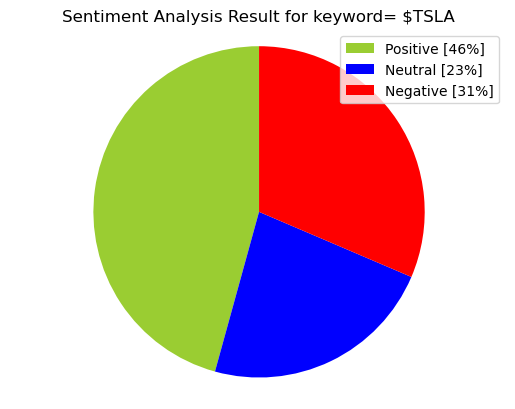

In [41]:
#Creating PieCart**

labels = ['Positive ['+str(round(positive))+'%]' , 'Neutral ['+str(round(neutral))+'%]','Negative ['+str(round(negative))+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword= "+query+"" )
plt.axis('equal')
plt.show()